# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [18]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
import sklearn.decomposition
import numpy as np
from sklearn.cluster import KMeans, AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from scipy.spatial.distance import cdist
import matplotlib.cm as cm
import warnings

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

print('Libraries Loaded')

Libraries Loaded


## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [19]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


### 1b. Explore the data

In [20]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [21]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [22]:
# Think about calling merge() on df_transactions and df_offers
merged = pd.merge(df_transactions, df_offers)

# We now want to make a pivot table
pivoted = merged.pivot_table(index='customer_name', columns='offer_id', values='n', fill_value=0)

pivoted

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Williams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Wilson,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
Wood,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change fr

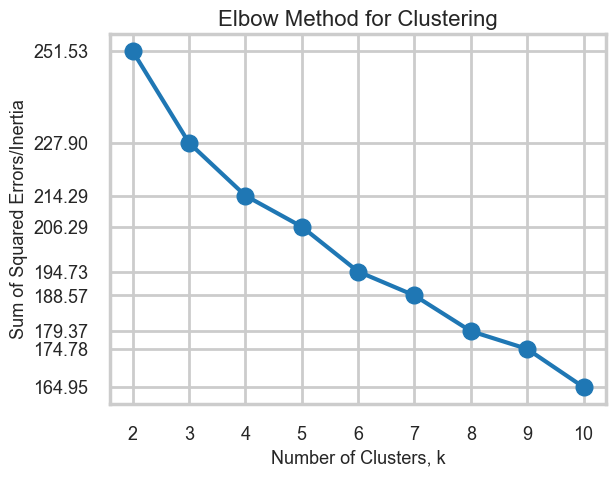

In [23]:
# 3. Extract Offer Columns
x_cols = pivoted.to_numpy()  # Convert to NumPy matrix
X = pivoted
Krange  = list(range(2, 11))

# 4. Apply KMeans and Calculate SS for K = 2 to 10
ss_values = []
for k in Krange:
    kmeans = KMeans(n_clusters=k, random_state=42) 
    kmeans.fit(x_cols)
    ss_values.append(kmeans.inertia_)  # Inertia_ attribute stores SS

#Construct a plot showing 𝑆𝑆 for each 𝐾 and pick 𝐾 using this plot. For simplicity, test 2≤𝐾≤1
plt.plot(Krange,ss_values,'-o')
plt.xlabel('Number of Clusters, k', fontsize=13)
plt.ylabel('Sum of Squared Errors/Inertia', fontsize=13)
plt.title('Elbow Method for Clustering', fontsize=16)
plt.xticks(Krange, fontsize=13)
plt.yticks(ss_values, fontsize=13)
plt.show()

Wow. It is hard to determine where the elbow is in the sum of squares chart. The lack of a clear "elbow" in the elbow curve for K-Means clustering can have several explanations:

1. The Data May Not Have Well-Defined Clusters: K-Means assumes well-separated, spherical clusters. If your data has irregular shapes, overlapping clusters, or a more uniform distribution, the elbow might not be prominent.

2. Inherent Noise in the Data: Real-world data often has noise and outliers. These can obscure the underlying cluster structure and make the elbow less distinct.

3. High Dimensionality: When dealing with high-dimensional data (many features), the notion of "distance" becomes less intuitive, making it harder to visually identify the elbow point.

4. Underlying Cluster Structure Might Not Be Spherical: K-Means works best with spherical clusters. Elongated or irregular clusters can lead to a less pronounced elbow.


Try Different K Values:

Experiment with a wider range of K values (beyond 4, 6, and 8) and compare the clustering results using metrics like explained variance ratio (Inertia) or silhouette score.
Alternative Clustering Algorithms:

Explore other clustering algorithms like DBSCAN (density-based) or Hierarchical clustering, which might be better suited for non-spherical or noisy data.
Remember:

The elbow method is a heuristic, not a definitive guide. Consider these explanations and alternative approaches to determine the optimal K value for your specific dataset and clustering task.

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


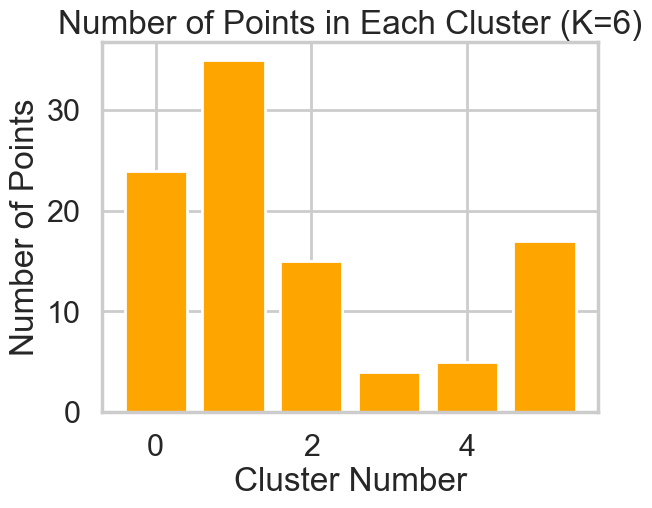

In [24]:
# 6. Select K based on Elbow (manually inspect the plot)
best_k = 6

# 7. Create Bar Chart for Best K
bar_color = 'orange'
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(x_cols)
cluster_labels = kmeans.labels_
plt.bar(range(best_k), np.bincount(cluster_labels), color=bar_color)
plt.xlabel("Cluster Number")
plt.ylabel("Number of Points")
plt.title("Number of Points in Each Cluster (K={})".format(best_k))
plt.show()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


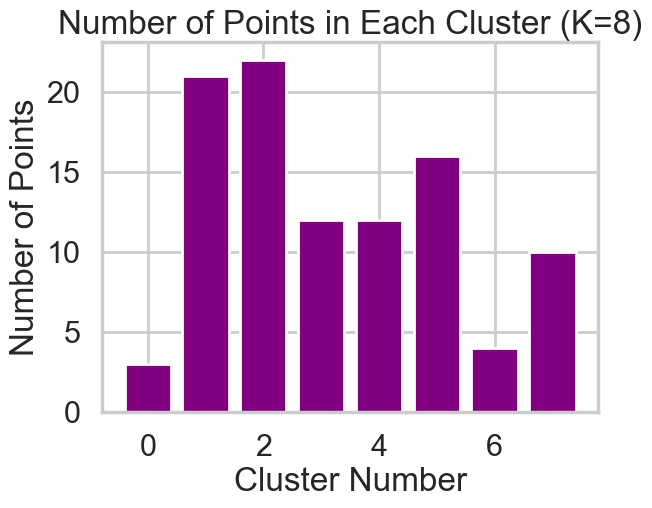

In [25]:
# 6. Select K based on Elbow (manually inspect the plot)
best_k = 8

# 7. Create Bar Chart for Best K
bar_color = 'purple'
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(x_cols)
cluster_labels = kmeans.labels_
plt.bar(range(best_k), np.bincount(cluster_labels), color=bar_color)
plt.xlabel("Cluster Number")
plt.ylabel("Number of Points")
plt.title("Number of Points in Each Cluster (K={})".format(best_k))
plt.show()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


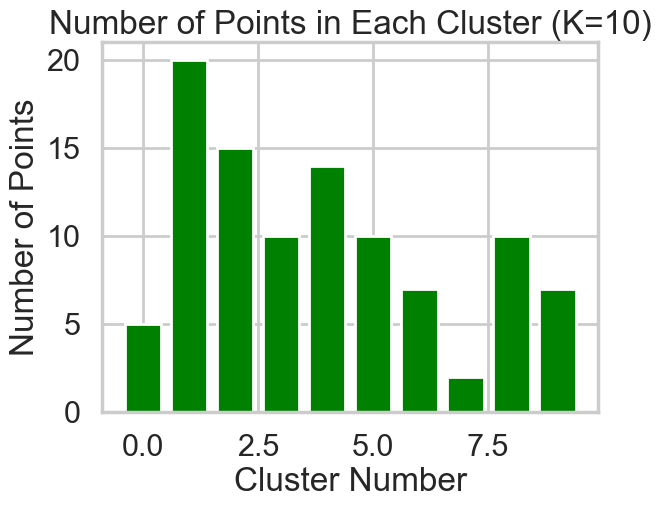

In [26]:
# 6. Select K based on Elbow (manually inspect the plot)
best_k = 10

# 7. Create Bar Chart for Best K
bar_color = 'green'
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(x_cols)
cluster_labels = kmeans.labels_
plt.bar(range(best_k), np.bincount(cluster_labels), color=bar_color)
plt.xlabel("Cluster Number")
plt.ylabel("Number of Points")
plt.title("Number of Points in Each Cluster (K={})".format(best_k))
plt.show()

## 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change fr

For K = 2, the average silhouette score is: 0.0917
For K = 3, the average silhouette score is: 0.1181
For K = 4, the average silhouette score is: 0.1203
For K = 5, the average silhouette score is: 0.1020
For K = 6, the average silhouette score is: 0.1087
For K = 7, the average silhouette score is: 0.1179


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For K = 8, the average silhouette score is: 0.1295
For K = 9, the average silhouette score is: 0.1187
For K = 10, the average silhouette score is: 0.1159


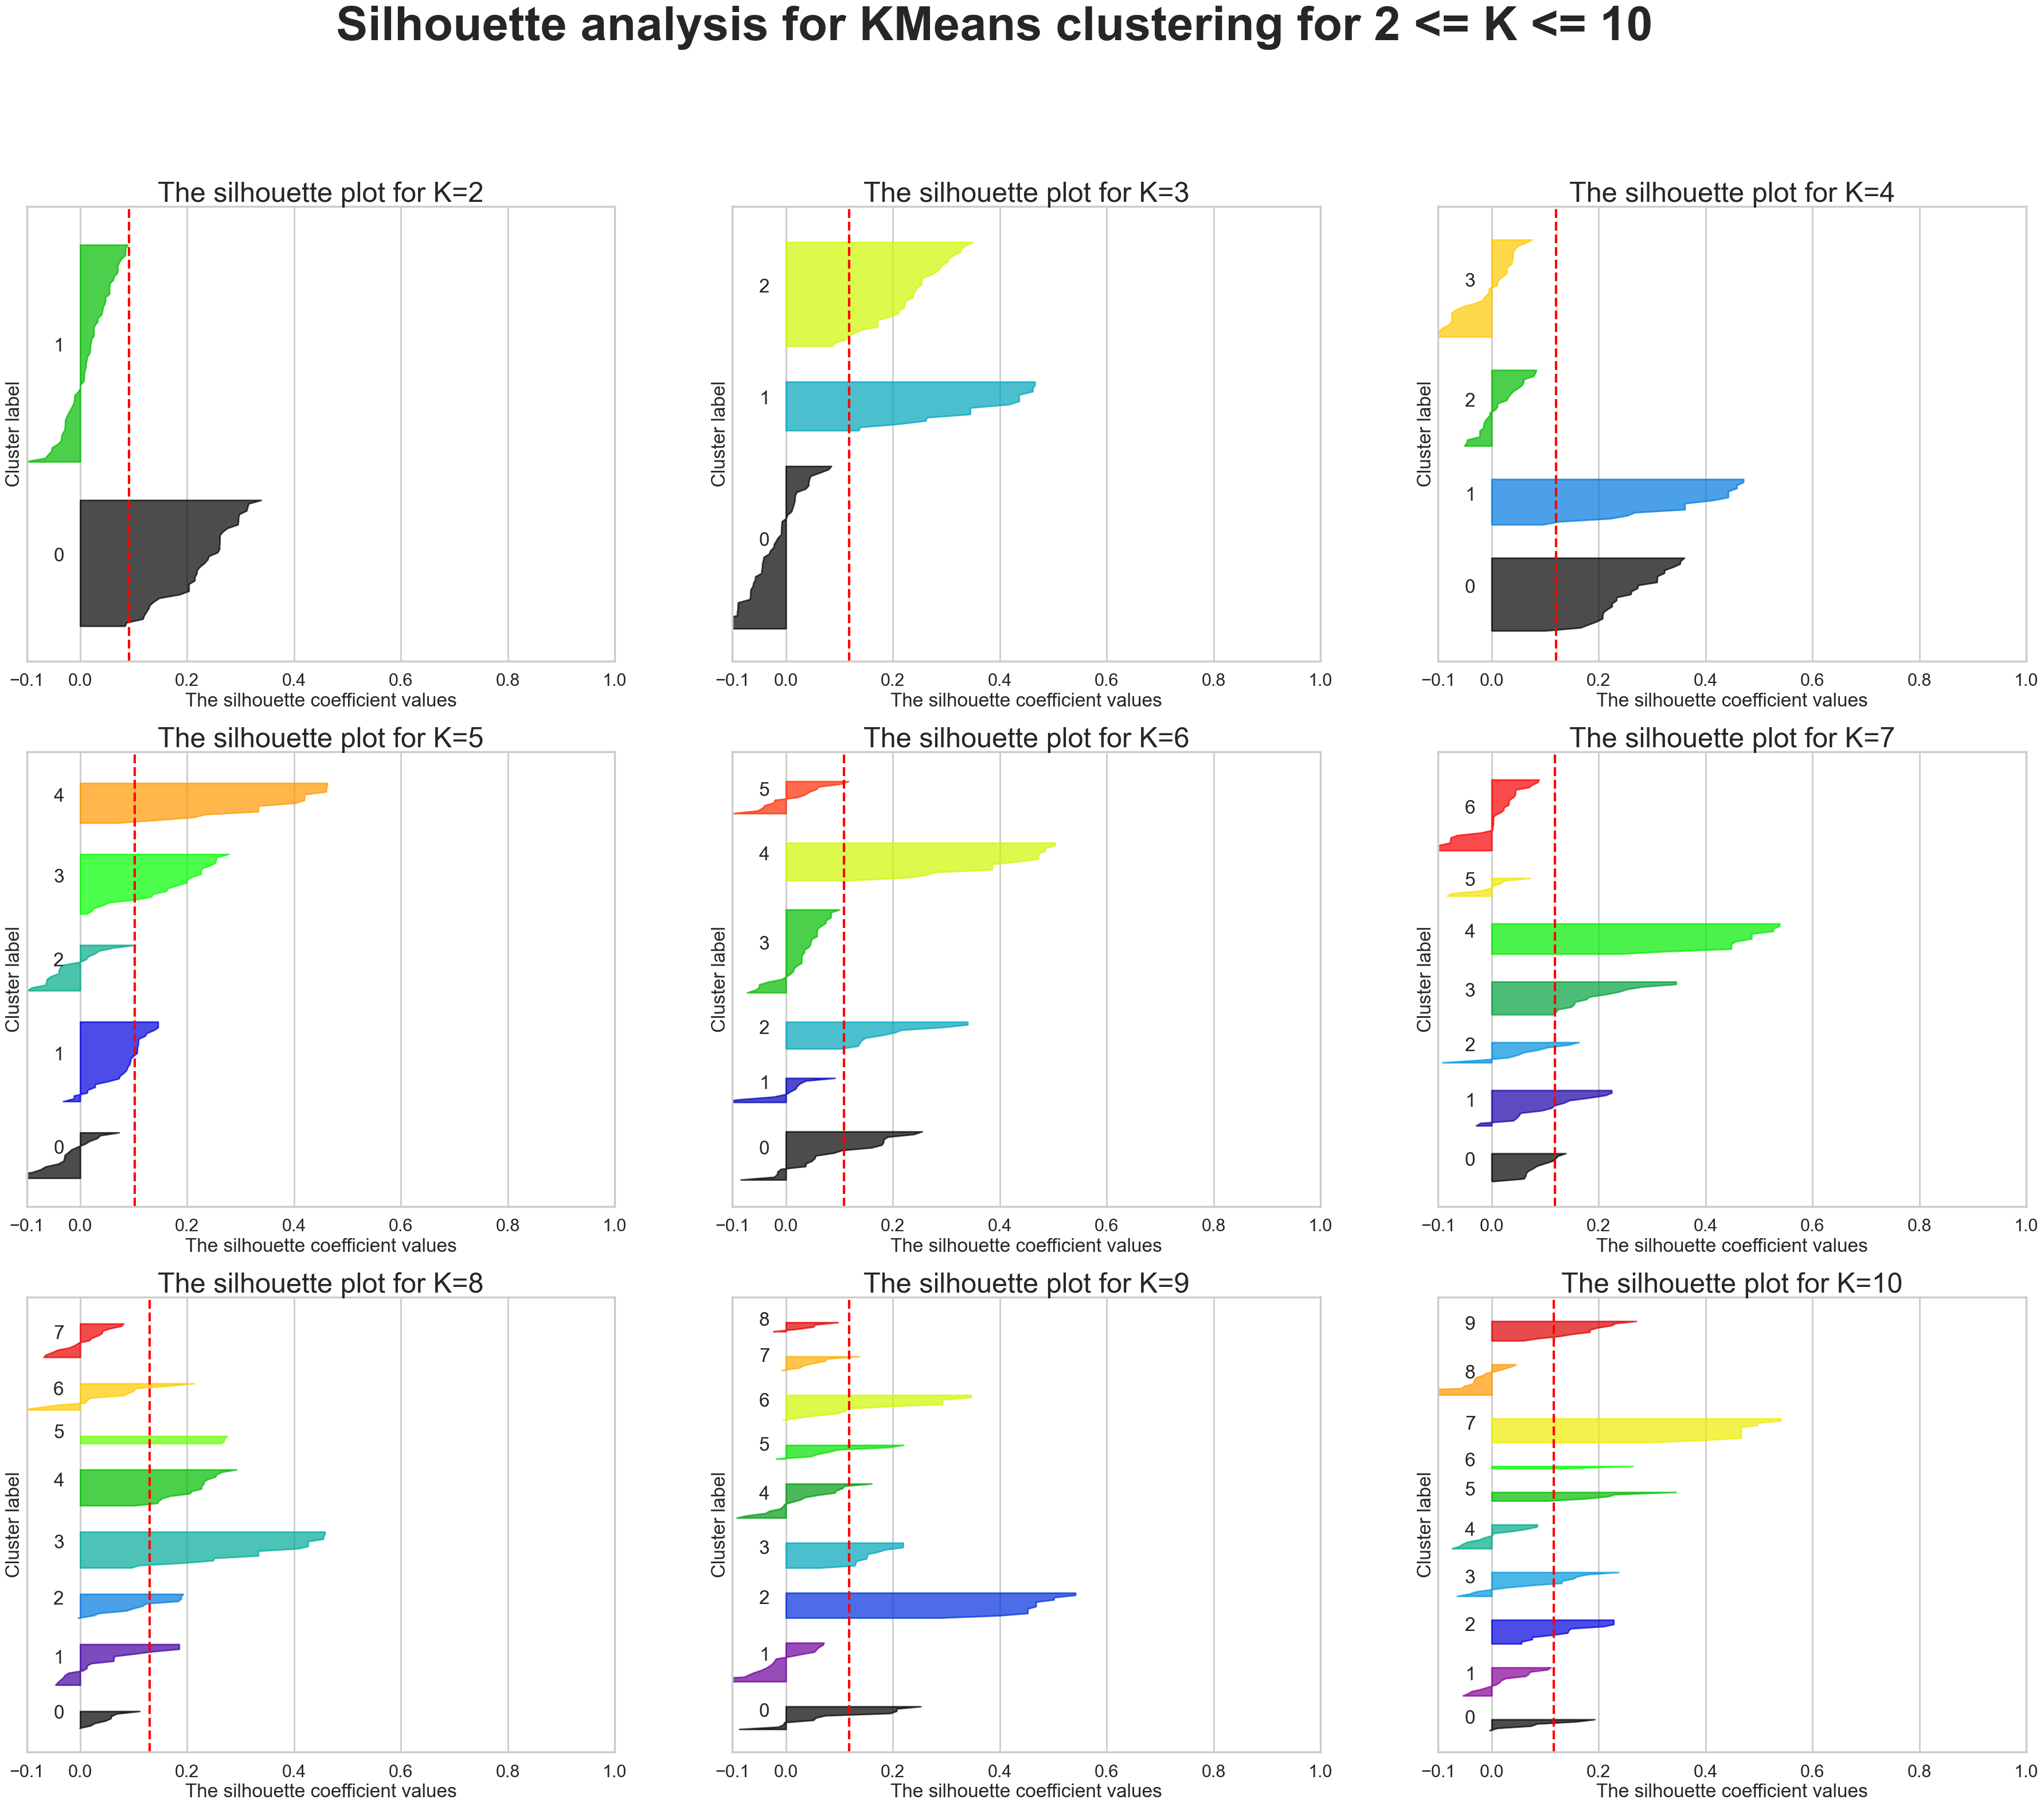

In [27]:
range_n_clusters = list(range(2,11))
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(45, 35)

silhouette_avg_scores = [] 

for idx, n_clusters in enumerate(range_n_clusters):
    x_axes = idx // 3
    y_axes = idx % 3
    
   
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax[x_axes][y_axes].set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax[x_axes][y_axes].set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    print("For K = {}, the average silhouette score is: {:0.4f}".format(n_clusters, silhouette_avg))

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)



    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax[x_axes][y_axes].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax[x_axes][y_axes].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax[x_axes][y_axes].set_title("The silhouette plot for K={}".format(n_clusters), fontsize=35)
    ax[x_axes][y_axes].set_xlabel("The silhouette coefficient values")
    ax[x_axes][y_axes].set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax[x_axes][y_axes].axvline(x=silhouette_avg, color="red", linestyle="--")
    ax[x_axes][y_axes].set_yticks([])  # Clear the yaxis labels / ticks
    ax[x_axes][y_axes].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering for 2 <= K <= 10"),
                 fontsize=60, fontweight='bold')


plt.savefig('The Silhouette coefficient values plot.png')
plt.show()

Silhouette Analysis is how to proceed when the elbow is not so obvious. Silhouette analysis to evaluate different K values. It considers both intra-cluster (cohesion) and inter-cluster (separation) distances, providing a more comprehensive assessment. It can be used to study the separation distance between the resulting clusters and can be considered a better method compared to the Elbow method.

Silhouette analysis also has added advantage to find the outliers if present in a cluster.

In this case, it looks like 8 or 9 may be the best choice for K as the silouttes are over the threshold line. This result does differ in the elbow curve. 

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

In [15]:
# def gap_analysis(X, Krange):
#     # Define number of reference datasets (can be adjusted)
#     n_references = 5

#     # Allocate memory for Gap statistic values
#     gap_values = np.zeros(len(Krange)) 

#     for i, k in enumerate(Krange):
#         # Create reference data with uniform distribution
#         reference_data = np.random.uniform(np.min(X), np.max(X), size=(n_references, len(X[0])))

#         # Calculate within-cluster distances for actual data and reference data
#         wcss_data = kmeans_wcss(X, k)
#         wcss_ref = np.array([kmeans_wcss(ref_data, k) for ref_data in reference_data])

#         # Calculate Gap statistic
#         gap_values[i] = np.mean(wcss_ref) - wcss_data

#     # Find optimal K based on Gap statistic (outside the for loop)
#     optimal_k = Krange[np.argmax(gap_values)]

#     return optimal_k, gap_values

# def kmeans_wcss(data, k):
#     kmeans = KMeans(n_clusters=k, random_state=42)  # Set random state for reproducibility
#     kmeans.fit(data)
#     centroids = kmeans.cluster_centers_
#     distances = cdist(data, centroids)
#     wcss = np.sum(distances.min(axis=1))

#     return wcss

# # Assuming you have other customer features in a DataFrame named 'customer_data'
# combined_data = pd.merge(df_transactions, df_offers, on='offer_id', how='left')
# print(combined_data)
# array = combined_data.to_records(index=False)
# # # Print data with index labels
# # print(combined_data.index.values, X)
# # # Print data with column labels
# # print(combined_data.columns.values, X)

# Krange = range(2, 11)  # Adjust as needed
# optimal_k, gap_values = gap_analysis(array, Krange)

# print("Optimal number of clusters (K):", optimal_k)


### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

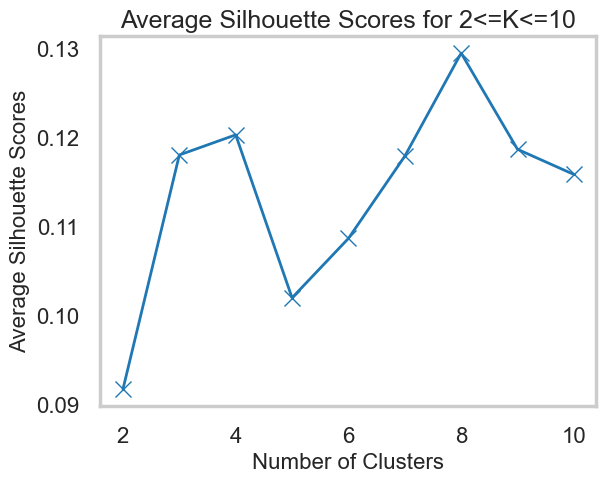

In [16]:
plt.plot(range(2,11), silhouette_avg_scores, linewidth=2, marker='x')
plt.xlabel("Number of Clusters", fontsize=16)
plt.ylabel("Average Silhouette Scores", fontsize=16)
plt.title("Average Silhouette Scores for 2<=K<=10", fontsize=18)
plt.grid(False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [30]:
# Create a PCA sample : pca
pca = PCA(n_components=2)

# Fit the Pca sample to the dataset
pca.fit(x_cols)

# Transform the dataset  
pca_features = pca.transform(x_cols)

# Print the shape of pca_features
print(pca_features.shape)

(100, 2)


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/vx/n4xm54gd5g15czs1d5cvl6_m0000gn/T/ipykernel_9097/2917229773.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  item_columns = pivoted.columns[[range(32)]]


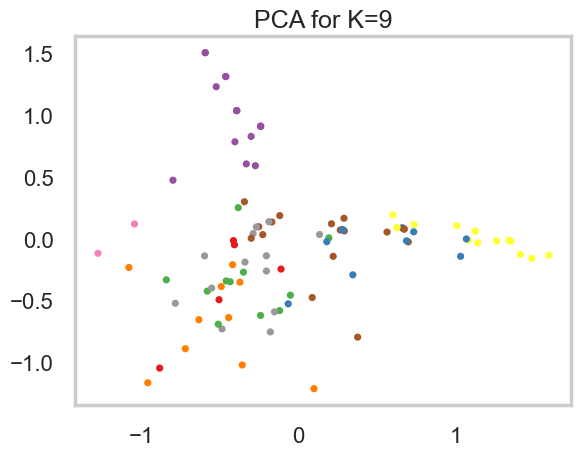

In [32]:
# label these pca_feature as 'x' and 'y'
x = pca_features[:,0]                       #or x , y = zip(*pca_features)
y = pca_features[:,1]    

# Get the clusters for customers (n_clusters=9 from the silhouette plot above)
clusters = KMeans(n_clusters=9, random_state=21)
pivoted['cluster_9'] = clusters.fit_predict(x_cols)

# add customer name, x and y to the df that we just created above
pivoted['x'] = x
pivoted['y'] = y

item_columns = pivoted.columns[[range(32)]]

# Plot a scatterplot of the `x` vs `y` columns
plt.scatter(pivoted['x'], pivoted['y'], c = pivoted['cluster_9'], 
            cmap='Set1', s = 10)
plt.grid(False) 
plt.title("PCA for K=9", fontsize=18) 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


Let's bring it all together to visual each option.

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


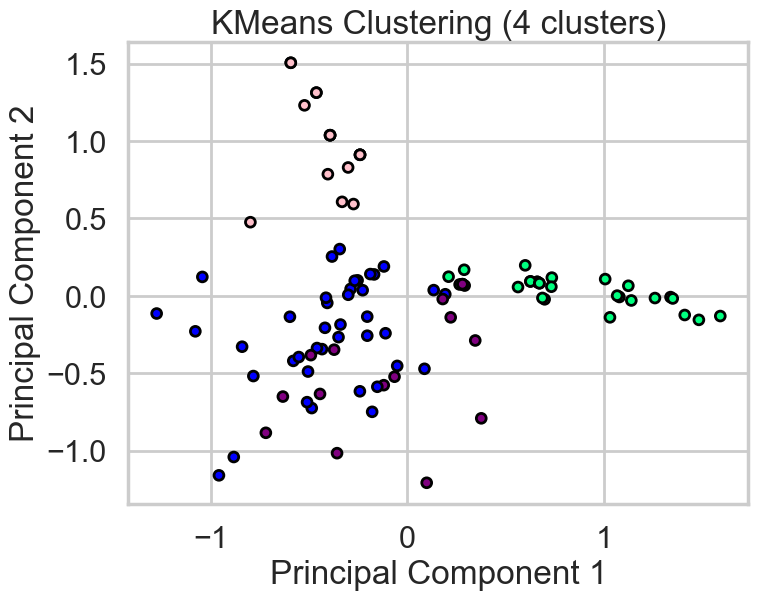

In [38]:
# KMeans (already defined previously)
model = KMeans(n_clusters=4)
cluster_assignments = model.fit_predict(x_cols)

# PCA for visualization (assuming X has two or more features)
pca = PCA(n_components=2)
pc1, pc2 = zip(*pca.fit_transform(x_cols))

# Visualization for KMeans
cmap = ListedColormap(['springgreen', 'aquamarine', 'blue', 'green','purple','pink'])
plt.figure(figsize=(8, 6))
plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap, edgecolors='k', s=50)
plt.title('KMeans Clustering (4 clusters)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

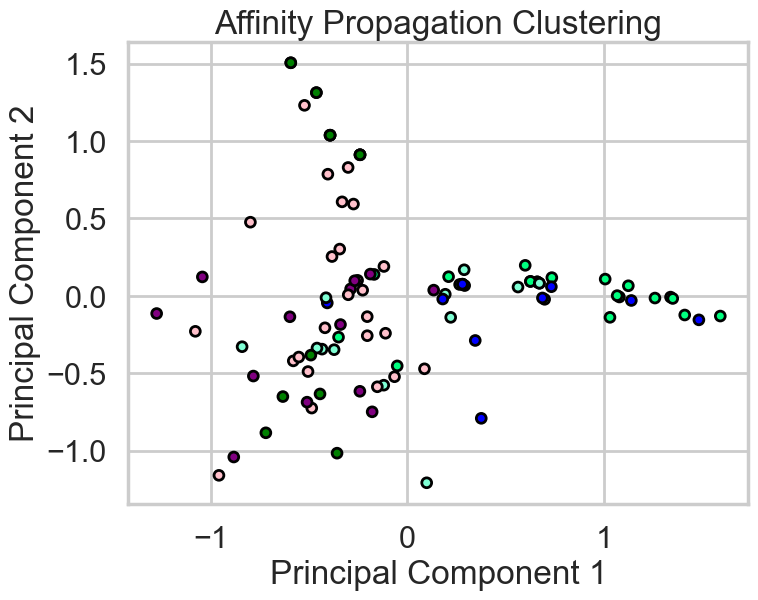

In [39]:
# Affinity Propagation
model = AffinityPropagation(damping=0.5)  # Adjust damping as needed
cluster_assignments = model.fit_predict(x_cols)

# Visualization for Affinity Propagation
plt.figure(figsize=(8, 6))
plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap, edgecolors='k', s=50)
plt.title('Affinity Propagation Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

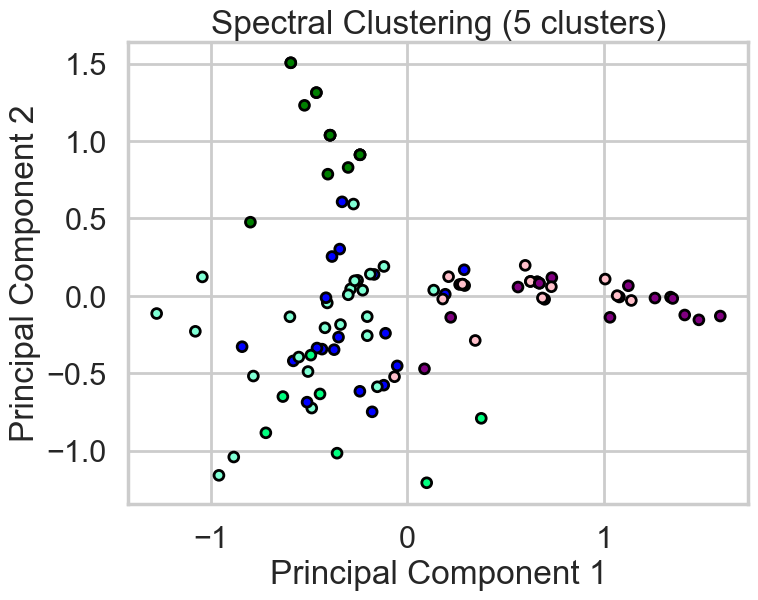

In [40]:
# Spectral Clustering
model = SpectralClustering(n_clusters=6, affinity='nearest_neighbors')  # Adjust parameters as needed
cluster_assignments = model.fit_predict(x_cols)

# Visualization for Spectral Clustering
plt.figure(figsize=(8, 6))
plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap, edgecolors='k', s=50)
plt.title('Spectral Clustering (5 clusters)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

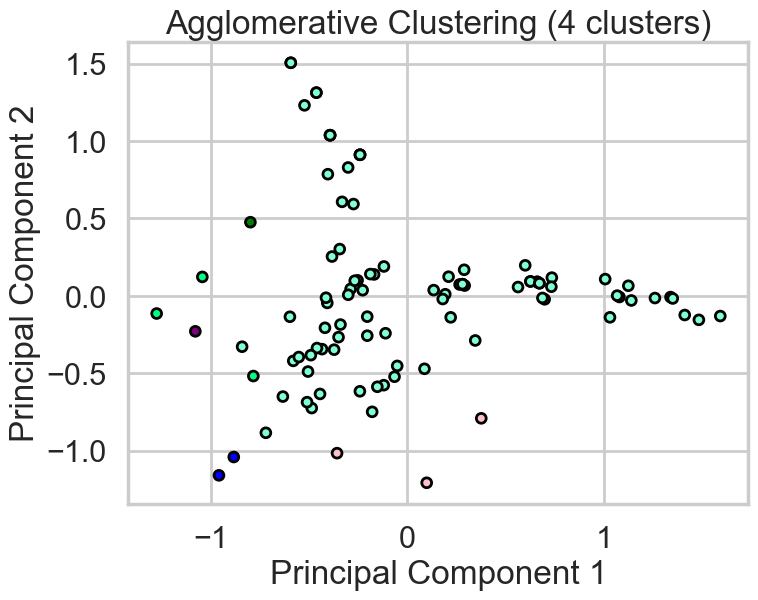

In [41]:
# Agglomerative Clustering
model = AgglomerativeClustering(linkage='average', n_clusters=6)  # Adjust linkage and n_clusters as needed
cluster_assignments = model.fit_predict(x_cols)

# Visualization for Agglomerative Clustering
plt.figure(figsize=(8, 6))
plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap, edgecolors='k', s=50)
plt.title('Agglomerative Clustering (4 clusters)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


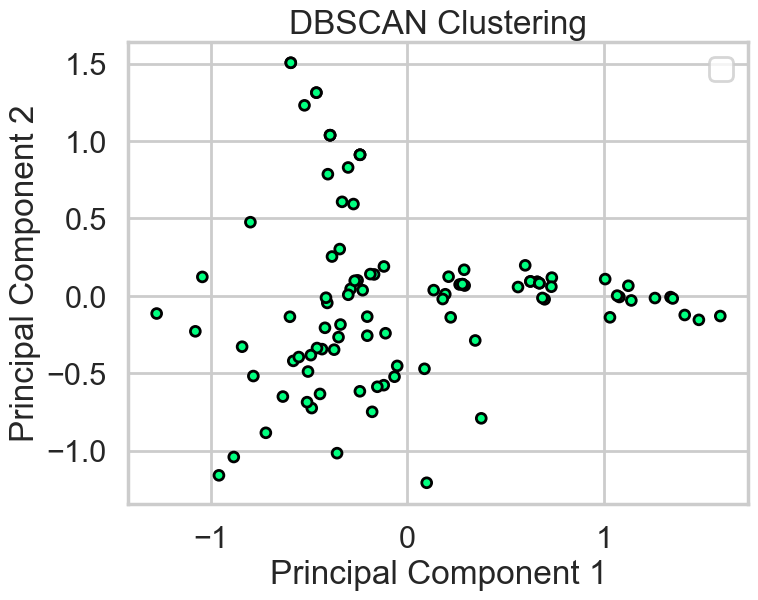

In [42]:
# DBSCAN
model = DBSCAN(eps=0.3, min_samples=10)  # Adjust eps and min_samples as needed
cluster_assignments = model.fit_predict(x_cols)

# Visualization for DBSCAN (handling outlier labels)
unique_labels = set(cluster_assignments)
colors = [cmap(i) if i in unique_labels else 'gray' for i in cluster_assignments]
plt.figure(figsize=(8, 6))
plt.scatter(pc1, pc2, c=colors, edgecolors='k', s=50)
plt.title('DBSCAN Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()  # Legend for normal clusters and outliers
plt.show()


In unsupervised learning tasks like customer segmentation based on offers received, interpreting the optimal number of customer groups (k) can be subjective. Clustering algorithms identify groups based on similarities in the data, but without predefined labels, assigning meaning to these clusters requires further analysis.

Two common validation techniques come into play: Silhouette analysis and the Elbow method. Silhouette analysis calculates a silhouette coefficient for each data point, measuring how well it's assigned to its cluster compared to neighbors. Higher scores indicate better separation. However, interpreting silhouette scores can be nuanced. Let's say your analysis resulted in scores that were acceptable for k=4, k=6, and k=8. While all options might have decent silhouette values, it wouldn't definitively point to a single optimal k.

The Elbow method tackles this issue from a different angle. It evaluates the total within-cluster sum of squares (WCSS) for different k values. As k increases, WCSS naturally decreases because you're continuously splitting the data into smaller groups. The Elbow method aims to identify the "elbow" point on the WCSS vs k graph. This is the point where the decrease in WCSS slows down significantly. Imagine analyzing the elbow plot and finding that while WCSS steadily drops from k=2 to k=8, the decrease between k=6 and k=8 is much smaller compared to the drops at lower k values. This suggests that k=6 might be a better choice, as adding more clusters beyond that point offers diminishing returns in terms of explaining the data's variance.

In your specific scenario, silhouette analysis might have indicated acceptable scores for k=4, k=6, and k=8, leaving some ambiguity. However, the Elbow method might have revealed a clear "elbow" at k=6, suggesting that splitting the data further (k=8) wouldn't provide much additional benefit.

By combining these techniques, you can gain a more comprehensive understanding of the optimal number of clusters and their distinctiveness. Analyzing the customer profiles within each segment (e.g., offer acceptance rates, purchase behavior) helps tailor marketing strategies for each group, maximizing the effectiveness of your offers and communication.